# Load dependencies and data

In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 11.9 MB/s 
     |████████████████████████████████| 3.3 MB 29.1 MB/s 
     |████████████████████████████████| 59 kB 7.1 MB/s 
     |████████████████████████████████| 895 kB 34.5 MB/s 
     |████████████████████████████████| 596 kB 34.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install emoji

     |████████████████████████████████| 170 kB 12.8 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=0a4879647bf9e2fd2d5d87ed3c35326bbc478d2dfe0d570e0e46cc0099245322
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import AdamW
import random
import re
from transformers import AutoModel, BertTokenizerFast
import emoji
import os
import matplotlib.pyplot as plt


# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks_2/Practice module')

Mounted at /content/gdrive


# Train data

In [5]:
data = pd.read_csv('tweets2class.csv')
tweets = data[['clean_text', 'sentiments']]
print(tweets.shape)

(600, 2)


In [6]:
# Perform tweets cleaning

def text_cleaning(text):
    text = text.lower()
    text = re.sub("@[A-Za-z0-9_]+"," ", text)
    text = re.sub("#[A-Za-z0-9_]+"," ", text)
    text = re.sub(r'([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9._-]+)', "", text)
    text = re.sub(r'(https|http|ftp)://([\w_]+(?:(?:\.[\w_-]+))[\w_.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', "", text)
    text = emoji.demojize(text)
    text = re.sub('RT', " ", text)
    text = re.sub('\n', " ", text)
    text = re.sub('\t', " ", text)
    text = " ".join(text.split())

    return text

tweets['clean_text'].apply(text_cleaning)

0      wishing will land somewhere in malaysia,thaila...
1      in singapore.... we had lockdown...after we re...
2      our government does take feedback ðÿ˜ƒ â€œfrom...
3      it appears as though you havenâ€:trade_mark:t ...
4      sure they do. they work at turning you into a ...
                             ...                        
595    look at the bright side! ðÿ˜ƒ reading this mea...
596    super excited about collaborating with aicadiu...
597    singapore did a much better job of controlling...
598    singapore has been under extreme restrictions ...
599    never have the folks â€œmandating anythingâ€,...
Name: clean_text, Length: 600, dtype: object

In [7]:
tweets = tweets[(tweets['sentiments']==-1)|(tweets['sentiments']==1)]
print(tweets.shape)

(600, 2)


In [8]:
tweets.head()

,clean_text,sentiments
0,"wishing will land somewhere in malaysia,thaila...",1
1,in singapore.... we had lockdown...after we re...,1
2,our government does take feedback ðÿ˜ƒ â€œfrom...,1
3,it appears as though you havenâ€:trade_mark:t ...,-1
4,sure they do. they work at turning you into a ...,-1


In [9]:
tweets.sentiments.value_counts()

 1    300
-1    300
Name: sentiments, dtype: int64

In [10]:
tweets['sentiments'] =  tweets['sentiments'].apply(lambda x: 0 if x == -1 else x)
tweets.sentiments.value_counts()

1    300
0    300
Name: sentiments, dtype: int64

In [11]:
# Split into train test validation sets

x_train, x_val, y_train, y_val = train_test_split(tweets['clean_text'],
                                                  tweets['sentiments'],
                                                  random_state = 1, 
                                                  train_size=0.7,
                                                  stratify= tweets['sentiments'])

# x_train, x_temp, y_train, y_temp = train_test_split(tweets['text_without_mentions'],
#                                                   tweets['sentiments'],
#                                                   random_state = 1, 
#                                                   train_size=0.7,
#                                                   stratify= tweets['sentiments'])

# x_val, x_test, y_val, y_test = train_test_split(x_temp,
#                                                 y_temp,
#                                                 random_state = 1,
#                                                 train_size = 0.5, 
#                                                 stratify = y_temp)


# Load BERT model and tokenizer

In [12]:
# Import BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [13]:
# Tokenize and encode text
# Set max length to be 32.
maxlen = 32

tokens_train = tokenizer.batch_encode_plus(
    x_train.tolist(),
    max_length = maxlen,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    x_val.tolist(),
    max_length = maxlen,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     x_test.tolist(),
#     max_length = maxlen,
#     padding=True,
#     truncation=True
# )


In [14]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(y_test.tolist())


In [15]:
# Create datasets and data loaders  for train and validation data

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during validation
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


# Define model

In [16]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True

In [43]:
# Define model architecture - to be customized!
class BERT_Model(nn.Module):

    def __init__(self, bert):
        super(BERT_Model,self).__init__()
        self.bert = bert 
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs) # first dense layer
      x = self.relu(x)      # Relu activation
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x
  
# pass the pre-trained BERT to our define architecture
model = BERT_Model(bert)

# push the model to GPU
model = model.to(device)

In [19]:
# Define optimizers

from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5) 

In [20]:
 # Balance classes
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

print("Class Weights:",class_weights)

Class Weights: [1. 1.]


In [21]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 


In [22]:
# function to train the model
def train():  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    if step % 100 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    
    # push the batch to gpu or CPU
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model.forward(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [23]:
# Evaluate model
def evaluate():
  
  print("\nEvaluating...")
  # deactivate dropout layers
  model.eval()
  total_loss = 0
  
  # empty list to save the model predictions
  total_preds = []
  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 500 batches.
    if step % 100 == 0 and not step == 0:      
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model.forward(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

# Train model with 2 dense layer and dropout = 0.1

Set epochs to 25


In [49]:
epochs = 25
# set initial loss to 1000
best_valid_loss = 1000.0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    


 Epoch 1 / 25

Evaluating...

Training Loss: 0.457
Validation Loss: 0.692

 Epoch 2 / 25

Evaluating...

Training Loss: 0.228
Validation Loss: 0.610

 Epoch 3 / 25

Evaluating...

Training Loss: 0.110
Validation Loss: 0.763

 Epoch 4 / 25

Evaluating...

Training Loss: 0.056
Validation Loss: 0.898

 Epoch 5 / 25

Evaluating...

Training Loss: 0.033
Validation Loss: 1.017

 Epoch 6 / 25

Evaluating...

Training Loss: 0.023
Validation Loss: 1.105

 Epoch 7 / 25

Evaluating...

Training Loss: 0.017
Validation Loss: 1.175

 Epoch 8 / 25

Evaluating...

Training Loss: 0.014
Validation Loss: 1.226

 Epoch 9 / 25

Evaluating...

Training Loss: 0.011
Validation Loss: 1.286

 Epoch 10 / 25

Evaluating...

Training Loss: 0.009
Validation Loss: 1.330

 Epoch 11 / 25

Evaluating...

Training Loss: 0.008
Validation Loss: 1.368

 Epoch 12 / 25

Evaluating...

Training Loss: 0.007
Validation Loss: 1.422

 Epoch 13 / 25

Evaluating...

Training Loss: 0.006
Validation Loss: 1.453

 Epoch 14 / 25

Eval

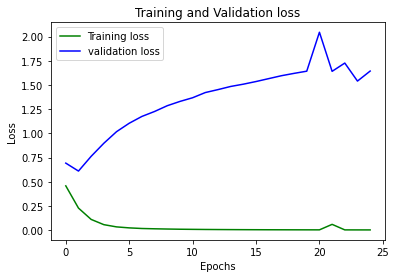

In [50]:
epochs = range(0,25)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

There is overfitting as the training and validation loss diverges at approx 5 epochs from the chart above. From the accuracy, this substantiate that there are overfitting.
Reduce complexity by using 1 dense layer for classifciation together with dropout of 0.5.

# Train model with reduced complexity

In [24]:
# Define model architecture - to be customized!
class BERT_Model(nn.Module):

    def __init__(self, bert):
        super(BERT_Model,self).__init__()
        self.bert = bert 
        self.dropout = nn.Dropout(0.5)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,2)
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs) # first dense layer
      x = self.relu(x)      # Relu activation
      x = self.softmax(x)

      return x
  
# pass the pre-trained BERT to our define architecture
model = BERT_Model(bert)

# push the model to GPU
model = model.to(device)

In [24]:
epochs = 10
# set initial loss to 1000
best_valid_loss = 1000.0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    


 Epoch 1 / 10

Evaluating...

Training Loss: 0.697
Validation Loss: 0.688

 Epoch 2 / 10

Evaluating...

Training Loss: 0.681
Validation Loss: 0.684

 Epoch 3 / 10

Evaluating...

Training Loss: 0.661
Validation Loss: 0.674

 Epoch 4 / 10

Evaluating...

Training Loss: 0.628
Validation Loss: 0.649

 Epoch 5 / 10

Evaluating...

Training Loss: 0.560
Validation Loss: 0.609

 Epoch 6 / 10

Evaluating...

Training Loss: 0.457
Validation Loss: 0.575

 Epoch 7 / 10

Evaluating...

Training Loss: 0.354
Validation Loss: 0.577

 Epoch 8 / 10

Evaluating...

Training Loss: 0.277
Validation Loss: 0.608

 Epoch 9 / 10

Evaluating...

Training Loss: 0.204
Validation Loss: 0.566

 Epoch 10 / 10

Evaluating...

Training Loss: 0.142
Validation Loss: 0.620


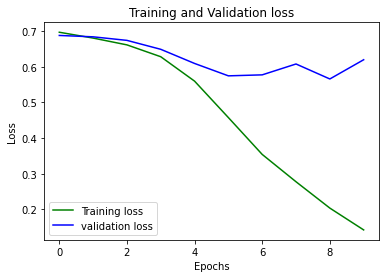

In [25]:
epochs_range = range(0,10)
plt.plot(epochs_range, train_losses, 'g', label='Training loss')
plt.plot(epochs_range, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
epochs = 5
# set initial loss to 1000
best_valid_loss = 1000.0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    


 Epoch 1 / 5

Evaluating...

Training Loss: 0.686
Validation Loss: 0.697

 Epoch 2 / 5

Evaluating...

Training Loss: 0.667
Validation Loss: 0.682

 Epoch 3 / 5

Evaluating...

Training Loss: 0.627
Validation Loss: 0.684

 Epoch 4 / 5

Evaluating...

Training Loss: 0.601
Validation Loss: 0.686

 Epoch 5 / 5

Evaluating...

Training Loss: 0.563
Validation Loss: 0.696


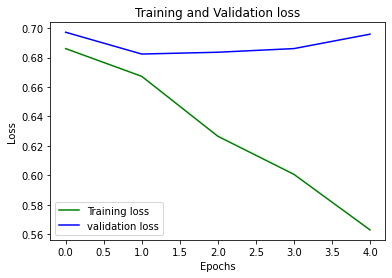

In [26]:
epochs_range = range(0,5)
plt.plot(epochs_range, train_losses, 'g', label='Training loss')
plt.plot(epochs_range, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions on train set with 5 epoch model with dropout = 0.5

In [27]:
#load weights of best model
path = 'BERT_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(train_seq.to(device), train_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(train_y, preds))

              precision    recall  f1-score   support

           0       0.82      0.47      0.60       210
           1       0.63      0.90      0.74       210

    accuracy                           0.68       420
   macro avg       0.73      0.68      0.67       420
weighted avg       0.73      0.68      0.67       420



# Predictions on val set with 5 epoch model with dropout = 0.5

In [28]:
#load weights of best model
path = 'BERT_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(val_seq.to(device), val_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.70      0.29      0.41        90
           1       0.55      0.88      0.68        90

    accuracy                           0.58       180
   macro avg       0.63      0.58      0.54       180
weighted avg       0.63      0.58      0.54       180

